In [1]:
import numpy as np

In [2]:
with open('Xids_train.npy', 'rb')as fp:
    Xids = np.load(fp)

with open('Xmask_train.npy', 'rb')as fp:
    Xmask = np.load(fp)

with open('Labels_train.npy', 'rb')as fp:
    labels = np.load(fp)

In [3]:
Xids.shape

(14323, 512)

In [4]:
labels.shape

(14323, 5)

In [5]:
import tensorflow as tf 
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [7]:
def map_func(input_ids, mask, labels):
    return {'input_ids': input_ids, 'attention_mask': mask}, labels

In [8]:
dataset = dataset.map(map_func)

In [9]:
dataset = dataset.shuffle(100000).batch(32)

In [10]:
SEQ_LEN = 512
NUM_CLASS = 5

In [11]:
DS_LEN = len(list(dataset))
DS_LEN

448

In [12]:
SPLIT = .8
train = dataset.take(round(DS_LEN*SPLIT))
val = dataset.skip(round(DS_LEN*SPLIT))

In [13]:
val

<SkipDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [14]:
del dataset

In [15]:
del Xids
del Xmask
del labels

In [16]:
from transformers import TFAutoModel, TFAutoModelForSequenceClassification

e:\python_enviroments\envs\nlpenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [18]:
NUM_CLASSES = 5

In [21]:
input_ids = tf.keras.layers.Input(shape= (SEQ_LEN, ), name= 'input_ids', dtype= 'int32')
mask = tf.keras.layers.Input(shape= (SEQ_LEN, ), name= 'attention_mask', dtype= 'int32')
embeddings = bert(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
y= tf.keras.layers.Dense(5, activation='softmax', name= 'outputs')(X)

model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)

model.layers[2].trainable = False

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [23]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer = optimizer, loss = loss, metrics= [acc])

In [24]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath= 'Xception.h5')] #setting up early stopping

In [26]:
model.fit(
    train, validation_data= val, epochs=15, batch_size=32,callbacks=callbacks,
)

Epoch 1/15


358/358 [==============================] - 409s 1s/step - loss: 0.6702 - accuracy: 0.7972 - val_loss: 0.2294 - val_accuracy: 0.9313
Epoch 2/15
358/358 [==============================] - 391s 1s/step - loss: 0.3684 - accuracy: 0.8686 - val_loss: 0.2431 - val_accuracy: 0.9114
Epoch 3/15
358/358 [==============================] - 394s 1s/step - loss: 0.3065 - accuracy: 0.8890 - val_loss: 0.1568 - val_accuracy: 0.9501
Epoch 4/15
358/358 [==============================] - 512s 1s/step - loss: 0.3022 - accuracy: 0.8966 - val_loss: 0.1512 - val_accuracy: 0.9491
Epoch 5/15
358/358 [==============================] - 401s 1s/step - loss: 0.3075 - accuracy: 0.8962 - val_loss: 0.1647 - val_accuracy: 0.9449
Epoch 6/15
358/358 [==============================] - 399s 1s/step - loss: 0.2923 - accuracy: 0.9011 - val_loss: 0.1151 - val_accuracy: 0.9616
Epoch 7/15
358/358 [==============================] - 397s 1s/step - loss: 0.2739 - accuracy: 0.9053 - val_loss: 0.1422 - val_accuracy: 0.9505
Epoch 8/15

In [28]:
import os
filename= 'bert_model_512_v3.h5'

# Delete the file if it already exists
if os.path.exists(filename):
    os.remove(filename)
# Save the model
model.save(filename)

# validating and getting materics

In [4]:
import pandas as pd

In [5]:
# Specify the file path where you want to save the CSV file
file_path = 'val_data.csv'
loaded_df = pd.read_csv(file_path)
loaded_df

,text,category
0,"Eso es por un lado , por_otro_lado debemos que...",B2
1,"Los fumadores no solamente empeoran su salud ,...",B2
2,"Hola , Mi familia se compone de tres miembres ...",A1
3,"Señores de la compañia de gas y electricidad ,...",C1
4,"Señores de la compañia de gas y electricidad ,...",C1
...,...,...
4471,¡ Hola ! ¿ Que tal ? Qiuro describir mi amiga ...,A2
4472,"buenos dìas , Mi llamo soukaina_X vivo en marr...",A2
4473,Estimdo empresa de avión : Hasta ahora sigo bu...,B1
4474,"La Universidad_de_Barcelona Damasco , 1_de_nov...",B2


In [6]:
from transformers import AutoTokenizer

#2847 Iis the max lenght of the texts
SEQ_LEN = 512

#i chose bert-base-cased because for me it's important to recognize the capital letters 
# in the text to identify the language level
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [7]:
Xids = []
Xmask = []

In [8]:
import numpy as np

Xids= np.zeros((len(loaded_df), SEQ_LEN))
Xmask= np.zeros((len(loaded_df), SEQ_LEN))

In [9]:
#casting text to String
loaded_df['text'] = loaded_df['text'].astype(str)

In [10]:
#checking type
for i, sequence in enumerate(loaded_df['text']):
    if not isinstance(sequence, str):
        print(f"Warning: 'text' at index {i} is not a string: {sequence}")

In [11]:
for i, sequence in enumerate(loaded_df['text']):
    encoded_token = tokenizer.encode_plus(
        sequence, 
        max_length= SEQ_LEN, 
        truncation= True, 
        padding= "max_length",
        add_special_tokens = True,
        return_token_type_ids = False,
        return_attention_mask = True,
        return_tensors = 'tf'
    )
    Xids[i,:], Xmask[i,:] = encoded_token['input_ids'],encoded_token['attention_mask']

In [12]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the encoder to the unique category strings and transform the 'category' column
loaded_df['numerical_category'] = label_encoder.fit_transform(loaded_df['category'])

# Display the DataFrame with the new 'numerical_category' column
print(loaded_df[['category', 'numerical_category']])


     category  numerical_category
0          B2                   3
1          B2                   3
2          A1                   0
3          C1                   4
4          C1                   4
...       ...                 ...
4471       A2                   1
4472       A2                   1
4473       B1                   2
4474       B2                   3
4475       A2                   1

[4476 rows x 2 columns]


In [13]:
arr = loaded_df['numerical_category'].values
arr.size

4476

In [14]:
labels = np.zeros((arr.size, arr.max()+1))
labels.shape

(4476, 5)

In [15]:
labels[np.arange(arr.size), arr] = 1
labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
saved_predictions = model.predict({'input_ids': Xids, 'attention_mask' : Xmask})
saved_predictions

140/140 [==============================] - 116s 759ms/step


array([[0.0000000e+00, 1.5630654e-35, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00],
       [1.3378042e-25, 3.1453323e-23, 3.7268321e-24, 1.0000000e+00,
        5.7458724e-30],
       [9.9999642e-01, 3.4841473e-06, 1.3042141e-07, 7.6689106e-11,
        5.9325973e-12],
       ...,
       [8.4558515e-12, 2.0913879e-10, 1.0000000e+00, 8.7481042e-18,
        8.0528703e-16],
       [4.5335963e-17, 9.2151008e-24, 2.9666062e-28, 1.0000000e+00,
        5.6033324e-31],
       [6.5627064e-06, 9.9998891e-01, 4.5509423e-06, 3.4013687e-09,
        2.8801617e-15]], dtype=float32)

In [17]:
import numpy as np

# Assuming predictions is the array you provided
predictions = np.array(saved_predictions)

# Get the class label or index with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# Assuming you have a list of class labels
class_labels = ["A1", "A2", "B1", "B2", "C1"]
predicted_class


array([3, 3, 0, ..., 2, 3, 1], dtype=int64)

In [18]:
# Get the class label or index with the highest probability
true_labels = np.argmax(labels, axis=1)
true_labels

array([3, 3, 0, ..., 2, 3, 1], dtype=int64)

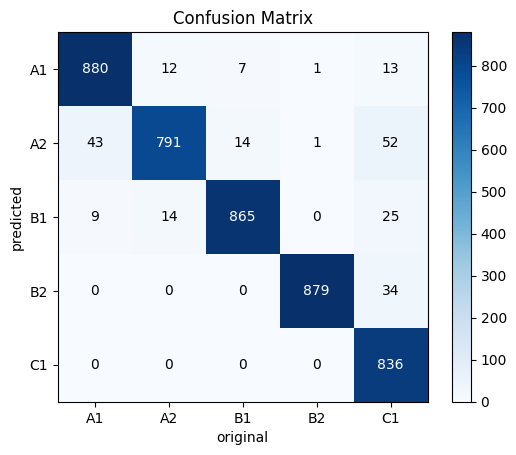

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_class)

# Display confusion matrix as a table
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(['A1', 'A2', 'B1','B2', 'C1'])
ax.set_yticklabels(['A1', 'A2', 'B1','B2', 'C1'])
plt.xlabel("original")
plt.ylabel("predicted")

# Add values inside the confusion matrix cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'  # Set font color based on the cell value
        ax.text(j, i, cm[i, j], ha="center", va="center", color=color)

plt.title("Confusion Matrix")
plt.colorbar(im)
plt.show()

In [20]:
import numpy as np

# Assuming predictions is the array you provided
predictions = np.array(saved_predictions)

# Get the class label or index with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# Assuming you have a list of class labels
class_labels = ["A1", "A2", "B1", "B2", "C1"]
predicted_class


array([3, 3, 0, ..., 2, 3, 1], dtype=int64)

In [21]:
from sklearn.metrics import classification_report

# Get the class with the highest probability as the predicted class
predicted_classes = [np.argmax(pred) for pred in predictions]

# Generate the classification report
report = classification_report(true_labels, predicted_classes)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       913
           1       0.97      0.88      0.92       901
           2       0.98      0.95      0.96       913
           3       1.00      0.96      0.98       913
           4       0.87      1.00      0.93       836

    accuracy                           0.95      4476
   macro avg       0.95      0.95      0.95      4476
weighted avg       0.95      0.95      0.95      4476



In [22]:
# kill kernel

import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

: 